# FMLIKH Model: Steady-State Flow Curves

## What is FMLIKH?

The **Fractional Multi-Lambda IKH (FMLIKH)** model extends single-mode FIKH to **N parallel structural modes**, combining two complementary relaxation mechanisms:

1. **Multi-mode structure**: N distinct populations $\lambda_i$ with different timescales $\tau_{thix,i}$
2. **Fractional kinetics**: Each mode evolves via Caputo derivative $D_t^{\alpha_i} \lambda_i$ (power-law memory)

This "double spectrum" architecture captures materials with **hierarchical microstructure** where different structural levels recover on different timescales AND exhibit power-law memory within each level.

### Physical Foundation

FMLIKH addresses complex fluids with **multiple relaxation processes**:

- **Fast modes** ($\tau_1 \sim 0.1$-1 s): Local bond reformation, surface contacts
- **Medium modes** ($\tau_2 \sim 1$-10 s): Aggregate restructuring
- **Slow modes** ($\tau_3 \sim 10$-1000 s): Network-scale reorganization, aging

Each mode can have:
- Its own fractional order $\alpha_i$ (**per-mode**, `shared_alpha=False`)
- OR share a global $\alpha$ (**shared**, `shared_alpha=True`, default)

**Key physics**: The weighted yield stress $\sigma_y = \sigma_{y0} + \Delta\sigma_y \sum_i w_i \lambda_i$ reflects contributions from all structural levels. Each $\lambda_i$ evolves independently via fractional kinetics, enabling capture of stretched exponential recovery with power-law tails.

### When to Use FMLIKH

FMLIKH is appropriate for materials exhibiting:

- **Multiple distinct recovery timescales** (not captured by single-mode FIKH)
- **Broad relaxation spectra** spanning decades of frequency (SAOS)
- **Hierarchical structure**: Multiple particle sizes, aggregation levels, or bond types
- **Power-law memory at each level** (not just exponential multi-mode)

**Typical materials**: Complex waxy crude oils, hierarchical colloidal gels, cement pastes with aging, bidisperse/polydisperse suspensions.

**Decision tree**:
- Single timescale + power-law → Use FIKH (simpler)
- Multiple timescales + exponential → Use ML-IKH (integer-order)
- Multiple timescales + power-law → Use FMLIKH (this model)

> **Handbook:** See [FMLIKH documentation](../../docs/source/models/fikh/fmlikh.rst) for mode selection guidance and parameter estimation strategies, covering shared vs per-mode $\alpha$, AIC/BIC model selection, and hierarchical microstructure interpretation.

## Learning Objectives

1. Fit the **FMLIKH** model to flow curve data with N=3 modes
2. Understand **multi-mode relaxation** with fractional memory
3. Analyze mode contributions to total stress and relaxation spectrum
4. Compare single-mode FIKH vs multi-mode FMLIKH predictions
5. Use Bayesian inference for multi-modal parameter estimation
6. Calibrate parameters for downstream synthetic data generation (NB09, NB11)

## Prerequisites

- **NB01-NB06**: FIKH tutorials (single-mode concepts, fractional derivatives)
- Bayesian inference fundamentals
- Understanding of relaxation spectra (Prony series)

**Estimated Time:** 5-8 minutes (fast demo), 20-30 minutes (full run)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fmlikh_param_names,
    load_ml_ikh_flow_curve,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

# FAST_MODE: controlled by environment variable
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: FMLIKH Model

The **Fractional Multi-Layer IKH (FMLIKH)** model extends FIKH with multiple viscoelastic modes:

### Total Stress
$$
\sigma_{total} = \sum_{i=1}^{N} \sigma_i + \eta_{\infty} \dot{\gamma}
$$

Each mode $i$ has its own:
- $G_i$: Shear modulus
- $\eta_i$: Viscosity (defines $\tau_i = \eta_i / G_i$)
- $C_i$: Kinematic hardening modulus
- $\gamma_{dyn,i}$: Dynamic recovery parameter

### Shared Parameters
- Yield stress: $\sigma_{y0}$, $\Delta\sigma_y$
- Thixotropy: $\tau_{thix}$, $\Gamma$
- Fractional order: $\alpha$ (shared or per-mode)

### Why Multi-Mode?

1. **Broad relaxation spectra**: Real materials have multiple time scales
2. **Wide-frequency SAOS**: Single mode cannot capture full frequency range
3. **Complex startup**: Multiple overshoot features
4. **Prony-series-like**: Generalized Maxwell behavior

## 3. Load Data

In [3]:
# Load flow curve data
gamma_dot, stress = load_ml_ikh_flow_curve(instrument="ARES_up")

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.2f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Data points: 21
Shear rate range: [0.0100, 100.00] 1/s
Stress range: [0.75, 51.46] Pa


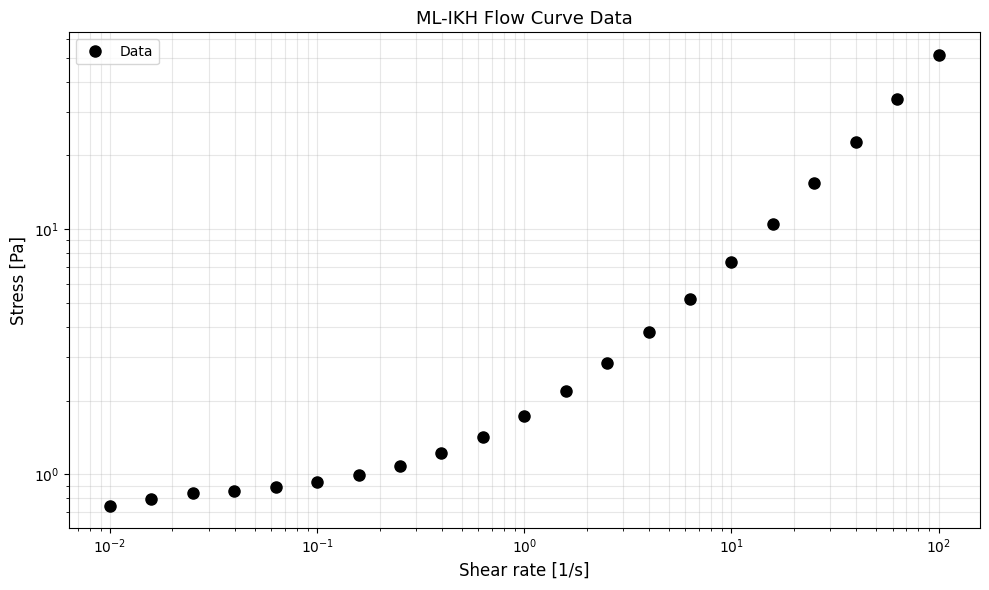

In [4]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=8, label="Data")
ax.set_xlabel("Shear rate [1/s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("ML-IKH Flow Curve Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create FMLIKH model with 3 modes
N_MODES = 3
model = FMLIKH(
    n_modes=N_MODES,
    include_thermal=False,
    shared_alpha=True,
    alpha_structure=0.7,
)

print(f"FMLIKH with {N_MODES} modes")
print(f"Shared alpha: True")
print(f"Total parameters: {len(list(model.parameters.keys()))}")

FMLIKH with 3 modes
Shared alpha: True
Total parameters: 20


In [6]:
# Fit model
t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    try:
        val = model.parameters.get_value(name)
        print(f"  {name:15s} = {val:.4g}")
    except KeyError:
        pass

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=20 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.605742s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=21 | final_cost=4.1340 | elapsed=1.606s | final_gradient_norm=2.8138e-08


NLSQ fit time: 1.88 s

Fitted parameters:
  G_0             = 1000
  eta_0           = 1e+06
  C_0             = 500
  gamma_dyn_0     = 1
  G_1             = 100
  eta_1           = 1e+05
  C_1             = 50
  gamma_dyn_1     = 1
  G_2             = 10
  eta_2           = 1e+04
  C_2             = 5
  gamma_dyn_2     = 1
  m               = 1
  sigma_y0        = 0.4427
  delta_sigma_y   = 5.1e-07
  tau_thix        = 4.368e+08
  Gamma           = 9771
  eta_inf         = 0.5046
  mu_p            = 0.002799
  alpha_structure = 0.7


In [7]:
# Get mode information
mode_info = model.get_mode_info()

print("\nMode Information:")
print("=" * 60)
print(f"Shared alpha: {mode_info.get('alpha_shared', 'N/A'):.3f}")
print("\nPer-mode parameters:")
print(f"{'Mode':>6s}  {'G [Pa]':>12s}  {'η [Pa.s]':>12s}  {'τ [s]':>12s}")
print("-" * 60)
for mode in mode_info["modes"]:
    print(f"{mode['mode']:>6d}  {mode['G']:>12.4g}  {mode['eta']:>12.4g}  {mode['tau']:>12.4g}")


Mode Information:
Shared alpha: 0.700

Per-mode parameters:
  Mode        G [Pa]      η [Pa.s]         τ [s]
------------------------------------------------------------
     0          1000         1e+06          1000
     1           100         1e+05          1000
     2            10         1e+04          1000



Fit Quality:
  R^2:   0.997611
  RMSE:  0.6275 Pa


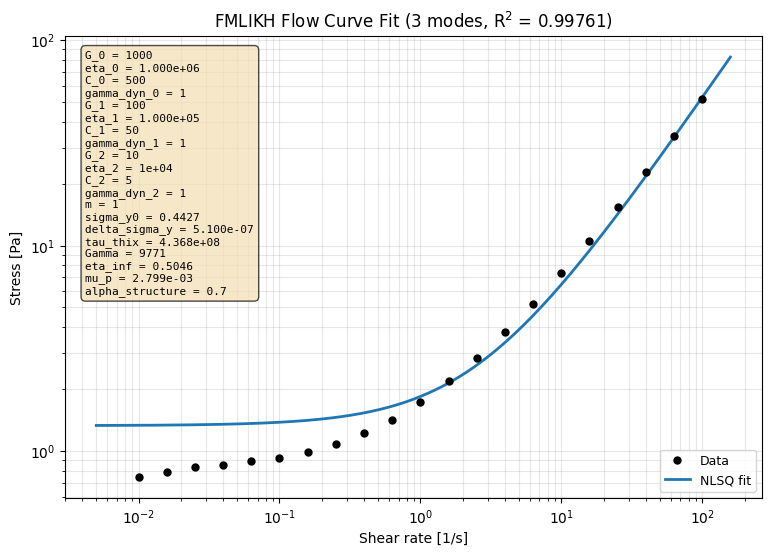

In [8]:
# Compute fit quality and plot with uncertainty band
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

fig, ax = plot_nlsq_fit(
    gamma_dot, stress, model, test_mode="flow_curve",
    param_names=param_names, log_scale=True,
    xlabel="Shear rate [1/s]", ylabel="Stress [Pa]",
    title=f"FMLIKH Flow Curve Fit ({N_MODES} modes, R$^2$ = {metrics['R2']:.5f})",
)
display(fig)
plt.close(fig)

## 5. Mode Decomposition

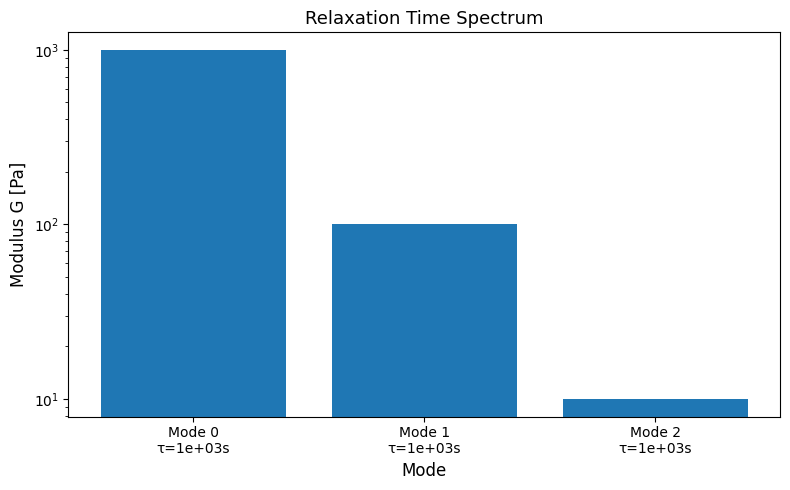

In [9]:
# Visualize relaxation time spectrum
mode_info = model.get_mode_info()

taus = [m["tau"] for m in mode_info["modes"]]
Gs = [m["G"] for m in mode_info["modes"]]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(len(taus)), Gs, tick_label=[f"Mode {i}\nτ={t:.2g}s" for i, t in enumerate(taus)])
ax.set_xlabel("Mode", fontsize=12)
ax.set_ylabel("Modulus G [Pa]", fontsize=12)
ax.set_title("Relaxation Time Spectrum", fontsize=13)
ax.set_yscale("log")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [10]:
# Bayesian inference
initial_values = {}
for name in param_names:
    try:
        initial_values[name] = model.parameters.get_value(name)
    except KeyError:
        pass

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<16:19,  1.40s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   3%|▎         | 22/700 [00:01<00:33, 20.01it/s, 255 steps of size 1.80e-02. acc. prob=0.80]

warmup:   6%|▌         | 40/700 [00:01<00:17, 38.46it/s, 255 steps of size 4.21e-03. acc. prob=0.82]

warmup:   9%|▊         | 60/700 [00:01<00:10, 61.05it/s, 255 steps of size 6.70e-03. acc. prob=0.84]

warmup:  11%|█▏        | 79/700 [00:01<00:07, 82.52it/s, 255 steps of size 6.85e-03. acc. prob=0.85]

warmup:  14%|█▍        | 98/700 [00:01<00:05, 102.68it/s, 255 steps of size 1.25e-02. acc. prob=0.86]

warmup:  17%|█▋        | 119/700 [00:02<00:04, 124.93it/s, 255 steps of size 1.11e-02. acc. prob=0.86]

warmup:  20%|█▉        | 138/700 [00:02<00:04, 137.58it/s, 255 steps of size 1.41e-02. acc. prob=0.87]

warmup:  23%|██▎       | 160/700 [00:02<00:03, 157.86it/s, 127 steps of size 5.09e-03. acc. prob=0.86]

warmup:  26%|██▌       | 183/700 [00:02<00:02, 176.00it/s, 127 steps of size 1.34e-02. acc. prob=0.87]

sample:  29%|██▉       | 205/700 [00:02<00:02, 185.03it/s, 255 steps of size 1.66e-02. acc. prob=0.98]

sample:  32%|███▏      | 226/700 [00:02<00:02, 186.14it/s, 255 steps of size 1.66e-02. acc. prob=0.97]

sample:  35%|███▌      | 247/700 [00:02<00:02, 189.21it/s, 255 steps of size 1.66e-02. acc. prob=0.97]

sample:  38%|███▊      | 267/700 [00:02<00:02, 189.95it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  41%|████      | 287/700 [00:02<00:02, 191.37it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  44%|████▍     | 307/700 [00:02<00:02, 191.25it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  47%|████▋     | 329/700 [00:03<00:01, 197.48it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  50%|█████     | 350/700 [00:03<00:01, 192.73it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  53%|█████▎    | 370/700 [00:03<00:01, 192.16it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  56%|█████▌    | 391/700 [00:03<00:01, 194.51it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  59%|█████▊    | 411/700 [00:03<00:01, 195.64it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  62%|██████▏   | 432/700 [00:03<00:01, 197.87it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  65%|██████▍   | 452/700 [00:03<00:01, 197.56it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  67%|██████▋   | 472/700 [00:03<00:01, 195.40it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  70%|███████   | 492/700 [00:03<00:01, 194.97it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  73%|███████▎  | 512/700 [00:04<00:00, 194.66it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  76%|███████▌  | 532/700 [00:04<00:00, 194.47it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  79%|███████▉  | 552/700 [00:04<00:00, 187.22it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  82%|████████▏ | 573/700 [00:04<00:00, 190.09it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  85%|████████▍ | 593/700 [00:04<00:00, 188.33it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  87%|████████▋ | 612/700 [00:04<00:00, 188.66it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  90%|█████████ | 631/700 [00:04<00:00, 188.54it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  93%|█████████▎| 651/700 [00:04<00:00, 191.75it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  96%|█████████▌| 671/700 [00:04<00:00, 189.72it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample:  99%|█████████▊| 691/700 [00:04<00:00, 192.33it/s, 255 steps of size 1.66e-02. acc. prob=0.96]

sample: 100%|██████████| 700/700 [00:05<00:00, 139.84it/s, 255 steps of size 1.66e-02. acc. prob=0.96]


Bayesian inference time: 7.5 s


In [11]:
# Convergence (check key parameters)
key_params = ["G_0", "G_1", "G_2", "alpha_structure", "sigma_y0", "tau_thix"]
all_pass = print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    0.9987       439      PASS
            G_1    0.9996       488      PASS
            G_2    0.9980      1135      PASS
alpha_structure    0.9982      1262      PASS
       sigma_y0    1.0009       700      PASS
       tau_thix    0.9993       798      PASS

Divergences: 0

All convergence criteria PASSED


### Convergence Diagnostics

**Bayesian Diagnostic Interpretation:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 minimum) |
| **Divergences** | < 1% | NUTS sampling quality |

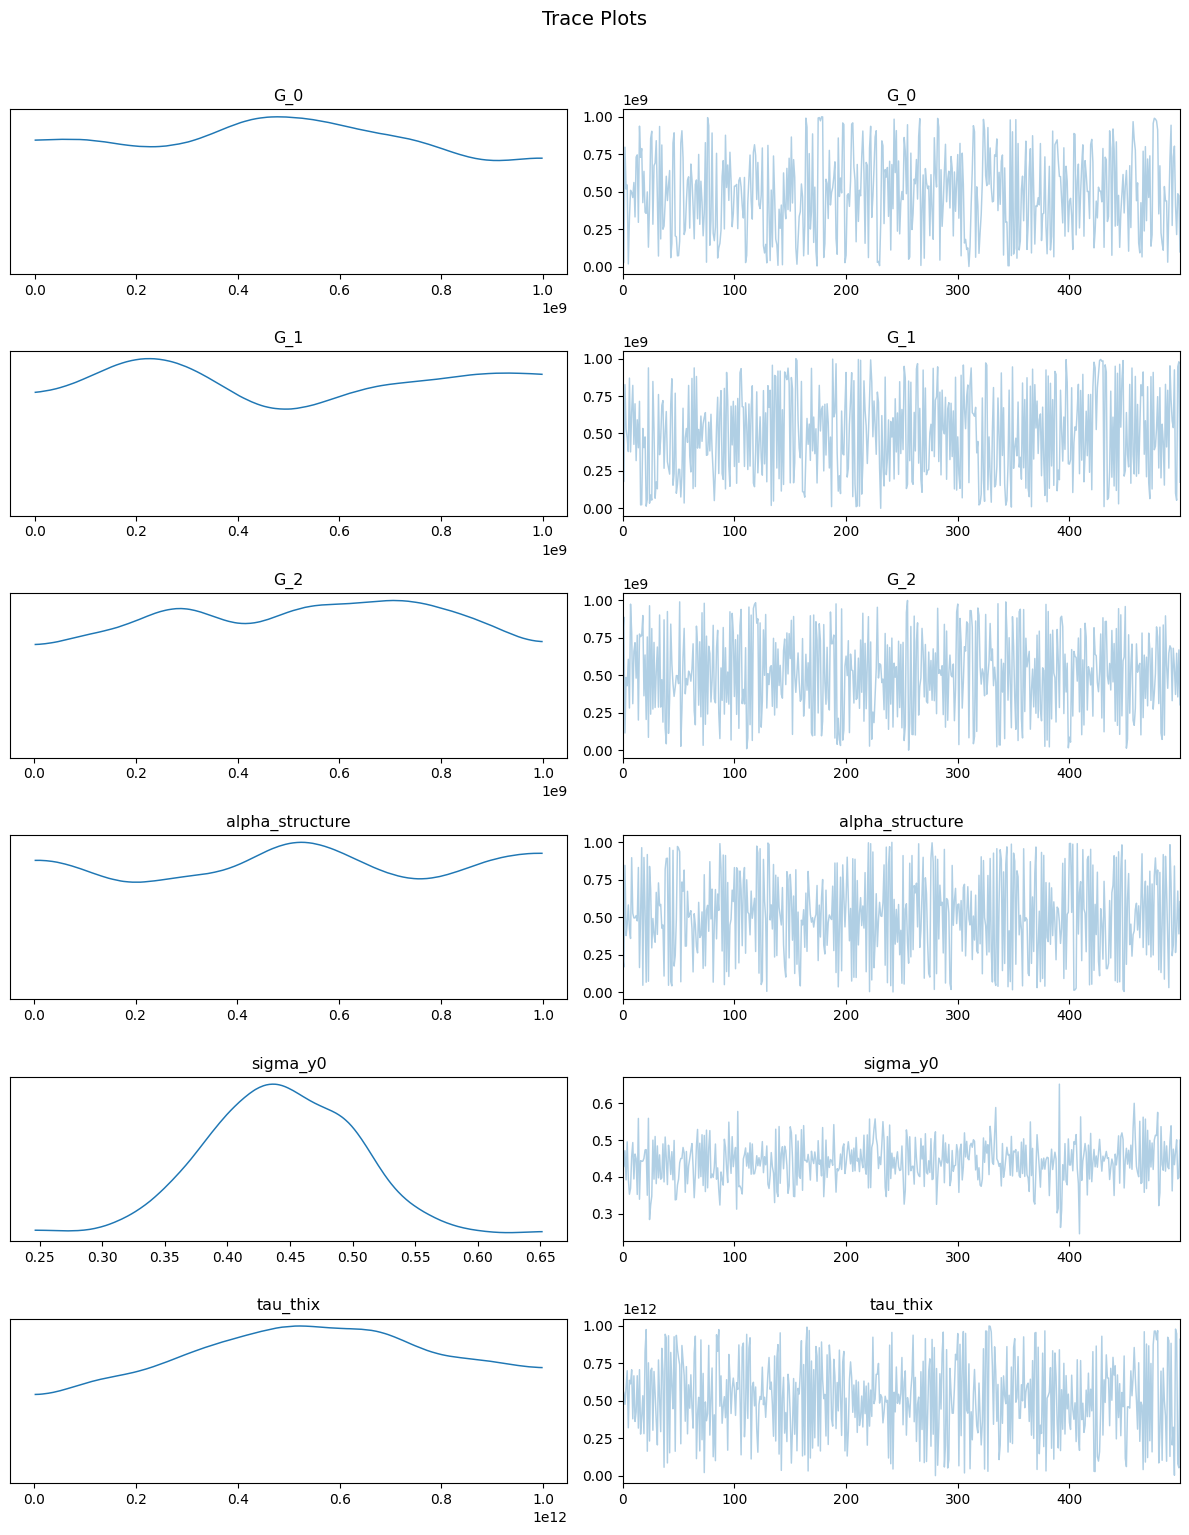

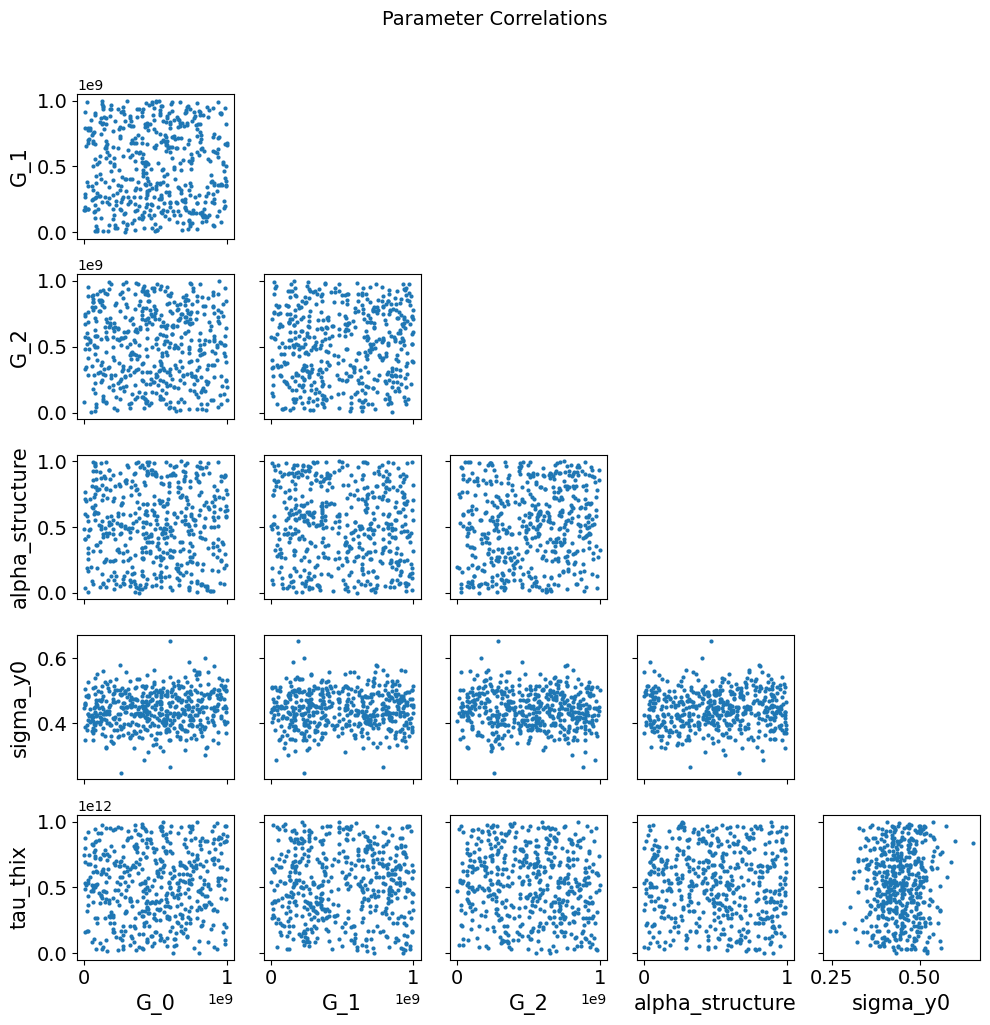

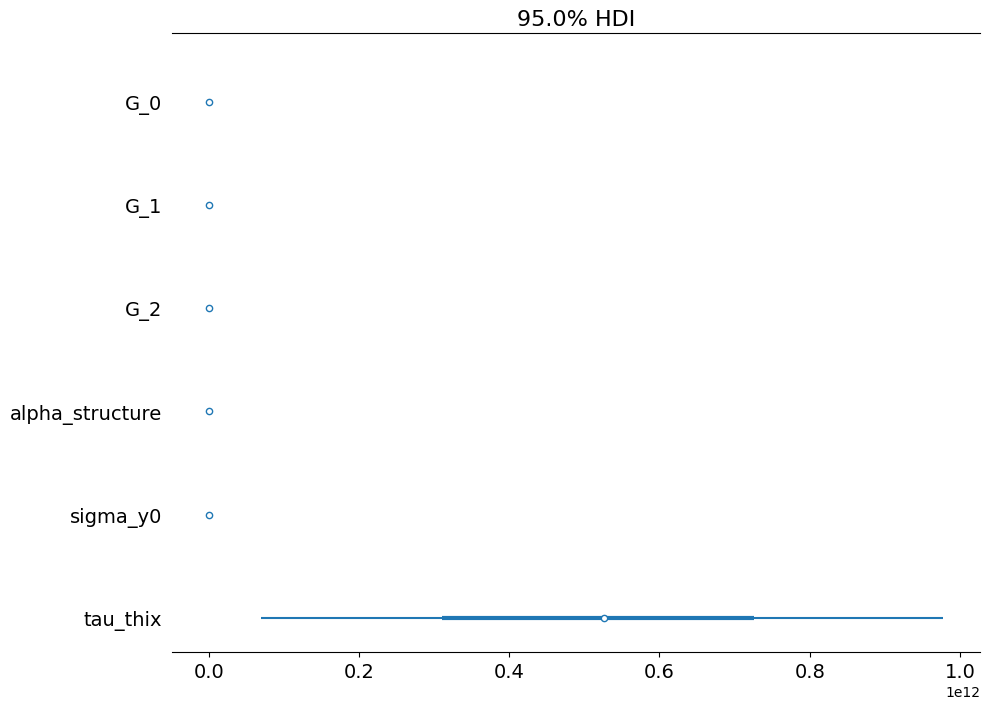

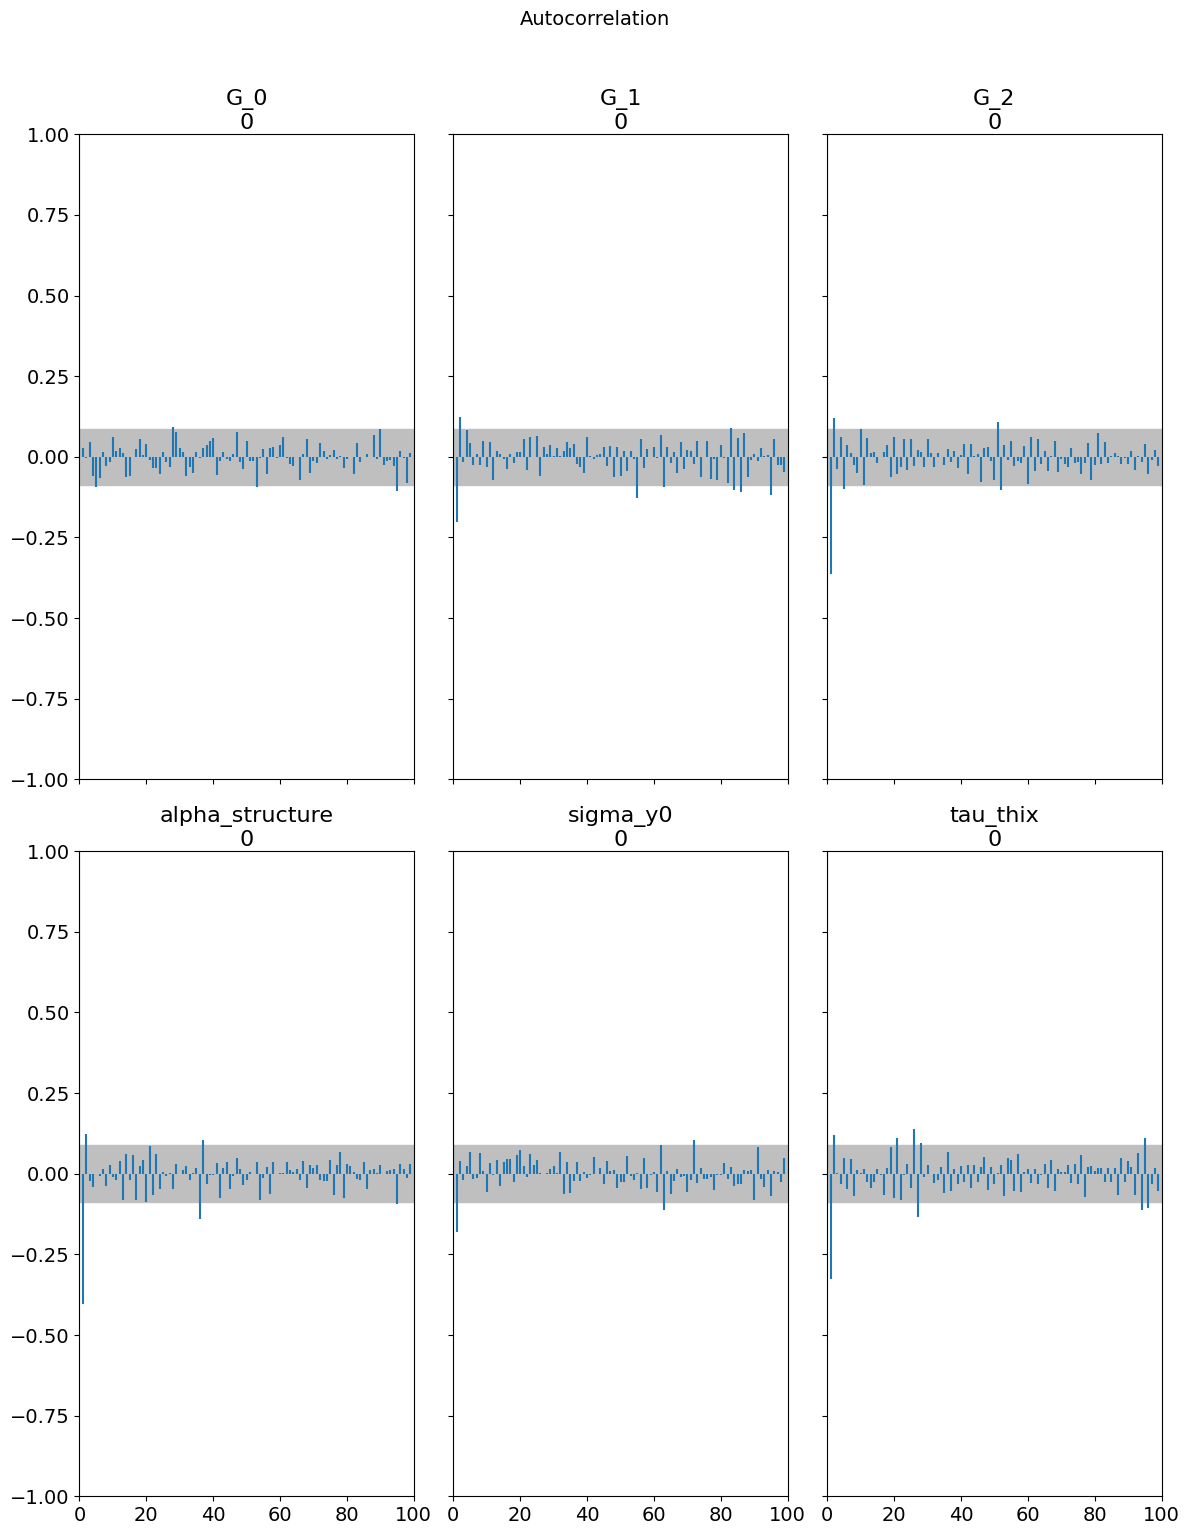

In [12]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, key_params, fast_mode=FAST_MODE)

In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, key_params)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
            G_0          1000     4.906e+08  [2.613e+07, 9.793e+08]
            G_1           100     4.987e+08  [2.36e+07, 9.773e+08]
            G_2            10     5.201e+08  [3.799e+07, 9.569e+08]
alpha_structure           0.7        0.5116  [0.03367, 0.9833]
       sigma_y0        0.4427         0.443  [0.3285, 0.5505]
       tau_thix     4.368e+08     5.258e+11  [4.482e+10, 9.623e+11]


## 7. Save Results

In [14]:
save_fikh_results(model, result, "fmlikh", "flow_curve", param_names)
print("\nParameters saved for synthetic data in NB09, NB11.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/flow_curve/
  nlsq_params_flow_curve.json: 20 parameters
  posterior_flow_curve.json: 500 draws

Parameters saved for synthetic data in NB09, NB11.


## Key Takeaways

1. **FMLIKH extends FIKH with multiple relaxation modes** ($N=2$-4 typical)
2. **Multi-mode captures broad relaxation spectra** spanning decades of timescales
3. **Shared alpha** (`shared_alpha=True`) reduces parameters while maintaining memory
4. **Mode decomposition** shows contribution of each structural level
5. **More parameters require careful initialization** and longer Bayesian inference
6. **Residual analysis** validates multi-mode fit quality across shear rate range

---

## Further Reading

### RheoJAX Handbook

- **[FMLIKH Model Documentation](../../docs/source/models/fikh/fmlikh.rst)**: Complete equations, mode selection (AIC/BIC), shared vs per-mode $\alpha$
- **[FMLIKH vs FIKH](../../docs/source/models/fikh/fmlikh.rst#relation-to-fikh)**: When to use multi-mode extension
- **[Mode Number Selection](../../docs/source/models/fikh/fmlikh.rst#mode-number-selection-aic-bic)**: Statistical criteria and practical rules

### Key References

**Multi-Mode Extensions:**
1. Wei, Y., Solomon, M.J., & Larson, R.G. (2018). "A multimode structural kinetics constitutive equation for the transient rheology of thixotropic elasto-viscoplastic fluids." *J. Rheol.*, 62(1), 321-342.

**Stretched Exponentials:**
2. Kohlrausch, R. (1854). "Theorie des elektrischen Rückstandes in der Leidener Flasche." *Ann. Phys.*, 167(2), 179-214.

**Fractional Foundations** (see NB01 references for Podlubny, Mainardi, Jaishankar)

### Next Steps

- **NB08**: Startup shear (multi-mode overshoot features)
- **NB09**: Stress relaxation (multi-exponential decay with power-law tails)
- **NB10**: Creep (distributed delay times)
- **NB11**: SAOS (broadened Cole-Cole depression)
- **NB12**: LAOS (multi-mode harmonics)